In [6]:
import re
import os
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from datetime import datetime
import time

def extract_movie_details(movie_url, options, service):
    try:
        browser = webdriver.Chrome(service=service, options=options)
        browser.get(movie_url)
        browser.implicitly_wait(10)
        page_source = browser.page_source
        soup = BeautifulSoup(page_source, "html.parser")

        box_office_data = {
            "Budget": None, 
            "Gross US & Canada": None, 
            "Opening Weekend US & Canada": None, 
            "Opening Weekend Date": None, 
            "Gross Worldwide": None
        }
        
        box_office_section = soup.find("section", {"data-testid": "BoxOffice"})
        if box_office_section:
            for item in box_office_section.find_all("li"):
                label_element = item.find("span", class_="ipc-metadata-list-item__label")
                value_element = item.find("span", class_="ipc-metadata-list-item__list-content-item")
                if label_element and value_element:
                    label = label_element.text.strip()
                    value = value_element.text.strip()
                    if label == "Opening weekend US & Canada":
                        box_office_data["Opening Weekend US & Canada"] = value.split()[0]  # Get the revenue part
                        date_element = item.find_all("span", class_="ipc-metadata-list-item__list-content-item")[1]
                        if date_element:
                            box_office_data["Opening Weekend Date"] = date_element.text.strip()
                    elif label == "Gross worldwide":
                        box_office_data["Gross Worldwide"] = value
                    else:
                        box_office_data[label] = value

        runtime = None
        color = None
        sound_mix = None
        aspect_ratio = None

        techspec_section = soup.find("section", {"data-testid": "TechSpecs"})
        if techspec_section:
            for item in techspec_section.find_all("li", class_="ipc-metadata-list__item"):
                label_element = item.find("span", class_="ipc-metadata-list-item__label")
                if label_element:
                    label = label_element.text.strip()
                    if label == "Runtime":
                        runtime_element = item.find("div", class_="ipc-metadata-list-item__content-container")
                        if runtime_element:
                            runtime = runtime_element.text.strip()
                    elif label == "Color":
                        color_element = item.find("a", class_="ipc-metadata-list-item__list-content-item")
                        if color_element:
                            color = color_element.text.strip()
                    elif label == "Sound mix":
                        sound_mix_element = item.find("a", class_="ipc-metadata-list-item__list-content-item")
                        if sound_mix_element:
                            sound_mix = sound_mix_element.text.strip()
                    elif label == "Aspect ratio":
                        aspect_ratio_element = item.find("span", class_="ipc-metadata-list-item__list-content-item")
                        if aspect_ratio_element:
                            aspect_ratio = aspect_ratio_element.text.strip()

        budget = box_office_data["Budget"]
        gross_us = box_office_data["Gross US & Canada"]
        open_week_rev = box_office_data["Opening Weekend US & Canada"]
        open_week_date = box_office_data["Opening Weekend Date"]
        gross_world = box_office_data["Gross Worldwide"]

        budget_num = int(re.sub("[A-Z£€₹$,()a-z]", "", budget)) if budget else None
        gross_us_num = int(re.sub("[A-Z£€₹$,()a-z]", "", gross_us)) if gross_us else None
        open_week_rev_num = int(re.sub("[A-Z£€₹$,()a-z]", "", open_week_rev).replace(",", "")) if open_week_rev else None
        open_week_date_std = datetime.strptime(open_week_date, "%b %d, %Y") if open_week_date else None
        gross_world_num = int(re.sub("[A-Z£€₹$,()a-z]", "", gross_world).replace(",", "")) if gross_world else None
        
        
        
        return {
            "Budget": budget_num,
            "Gross US & Canada": gross_us_num,
            "Opening Weekend US & Canada": open_week_rev_num,
            "Opening Weekend Date": open_week_date_std,
            "Gross Worldwide": gross_world_num,
            "Runtime": runtime,
            "Color": color,
            "Sound mix": sound_mix,
            "Aspect ratio": aspect_ratio
        }
    except Exception as e:
        print(f"Error extracting movie details from {movie_url}: {e}")
        return None

path = "C:\\Users\\ACER\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe"
my_url = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"

try:
    options = Options()
    options.headless = True
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    service = Service(path)
    
    browser = webdriver.Chrome(service=service, options=options)
    browser.get(my_url)
    browser.implicitly_wait(10)
    page_source = browser.page_source

    soup = BeautifulSoup(page_source, "html.parser")
    poster_cards = soup.find_all("div", class_="sc-b189961a-0 hBZnfJ cli-children")

    for poster_card in poster_cards:
        title_element = poster_card.find("div", class_="ipc-title ipc-title--base ipc-title--title ipc-title-link-no-icon ipc-title--on-textPrimary sc-b189961a-9 iALATN cli-title")
        
        # Handling metadata and ratingclass
        metadata_element = poster_card.find("div", class_="sc-b189961a-7 feoqjK cli-title-metadata")
        ratingclass = None
        if metadata_element:
            rating_elements = metadata_element.find_all("span", class_="sc-b189961a-8 kLaxqf cli-title-metadata-item")
            if len(rating_elements) > 2:  # Checking if there are enough elements
                ratingclass = rating_elements[2].text.strip()
        
        rating_element = poster_card.find("span", class_="ipc-rating-star--imdb")
        imdb_rating = rating_element.text.strip().split()[0]
        
        if title_element:
            title = title_element.find("a").text.strip()
            link = "https://www.imdb.com" + title_element.find("a")["href"]

            movie_details = extract_movie_details(link, options, service)
            if movie_details:
                print(f"Extracted data for {title}: {movie_details}")
                df = pd.DataFrame([{
                    "Title": title,
                    "Link": link,
                    "Classifications": ratingclass,
                    "IMDb Rating": imdb_rating,
                    "Budget": movie_details["Budget"],
                    "Gross US & Canada": movie_details["Gross US & Canada"],
                    "Opening Weekend US & Canada": movie_details["Opening Weekend US & Canada"],
                    "Opening Weekend Date": movie_details["Opening Weekend Date"],
                    "Gross Worldwide": movie_details["Gross Worldwide"],
                    "Runtime": movie_details["Runtime"],
                    "Color": movie_details["Color"],
                    "Sound mix": movie_details["Sound mix"],
                    "Aspect ratio": movie_details["Aspect ratio"]
                }])
                if os.path.exists("imdb_top_250.csv"):
                    df.to_csv("imdb_top_250.csv", mode='a', header=False, index=False)
                else:
                    df.to_csv("imdb_top_250.csv", index=False)
        time.sleep(2)  # Delay to avoid overloading the server

    browser.quit()
    print("Scraping completed and data saved to imdb_top_250.csv")

except Exception as e:
    print(f"Error during scraping: {e}")

    

Extracted data for 1. The Shawshank Redemption: {'Budget': 25000000, 'Gross US & Canada': 28767189, 'Opening Weekend US & Canada': 727327, 'Opening Weekend Date': datetime.datetime(1994, 9, 25, 0, 0), 'Gross Worldwide': 29330423, 'Runtime': '2 hours 22 minutes', 'Color': None, 'Sound mix': 'Dolby Digital', 'Aspect ratio': '1.85 : 1'}
Extracted data for 2. The Godfather: {'Budget': 6000000, 'Gross US & Canada': 136381073, 'Opening Weekend US & Canada': 302393, 'Opening Weekend Date': datetime.datetime(1972, 3, 19, 0, 0), 'Gross Worldwide': 250342030, 'Runtime': '2 hours 55 minutes', 'Color': 'Color', 'Sound mix': 'Mono', 'Aspect ratio': '1.85 : 1'}
Extracted data for 3. The Dark Knight: {'Budget': 185000000, 'Gross US & Canada': 534987076, 'Opening Weekend US & Canada': 158411483, 'Opening Weekend Date': datetime.datetime(2008, 7, 20, 0, 0), 'Gross Worldwide': 1008524647, 'Runtime': '2 hours 32 minutes', 'Color': 'Color', 'Sound mix': 'Dolby Digital', 'Aspect ratio': '2.39 : 1'}
Extract

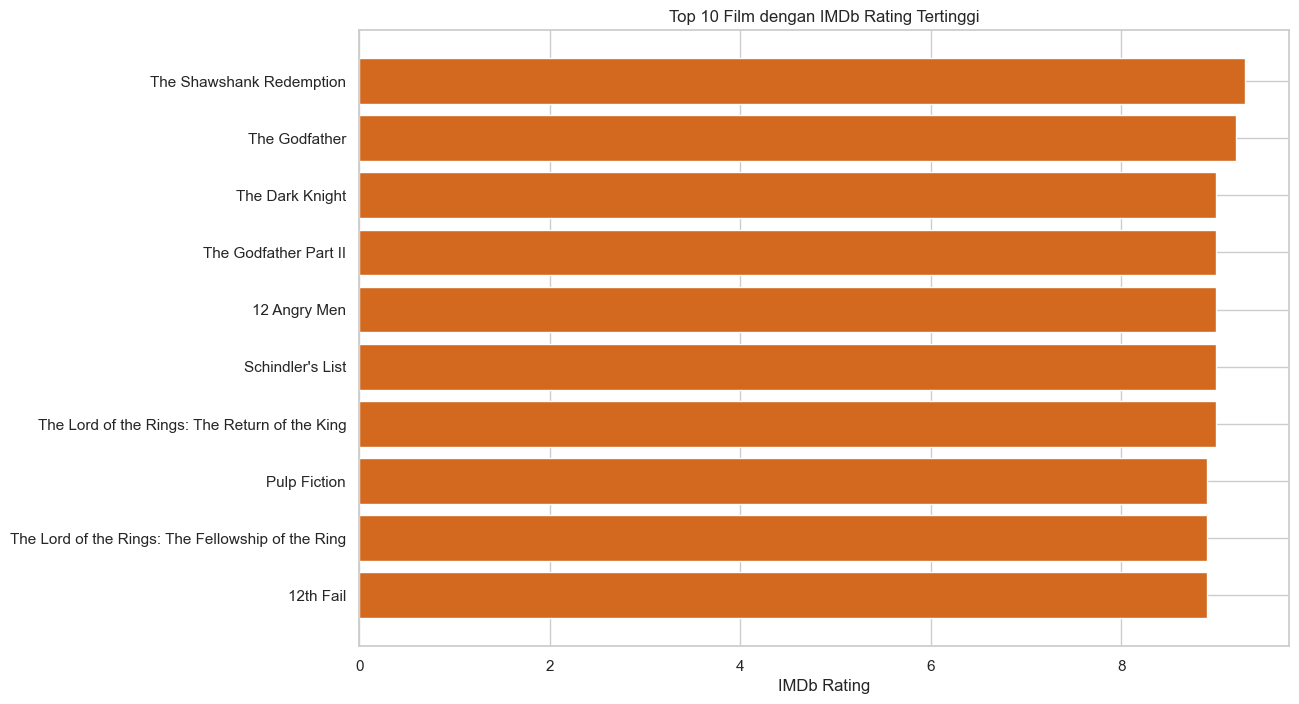

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Mengurutkan data berdasarkan IMDb Rating secara menurun
top_10_movies = data.sort_values(by='IMDb Rating', ascending=False).head(10)

# Plotting bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_10_movies['Title'], top_10_movies['IMDb Rating'], color='chocolate')
plt.xlabel('IMDb Rating')
plt.title('Top 10 Film dengan IMDb Rating Tertinggi')
plt.gca().invert_yaxis()  # Membalik urutan film agar yang rating tertinggi berada di atas
plt.show()

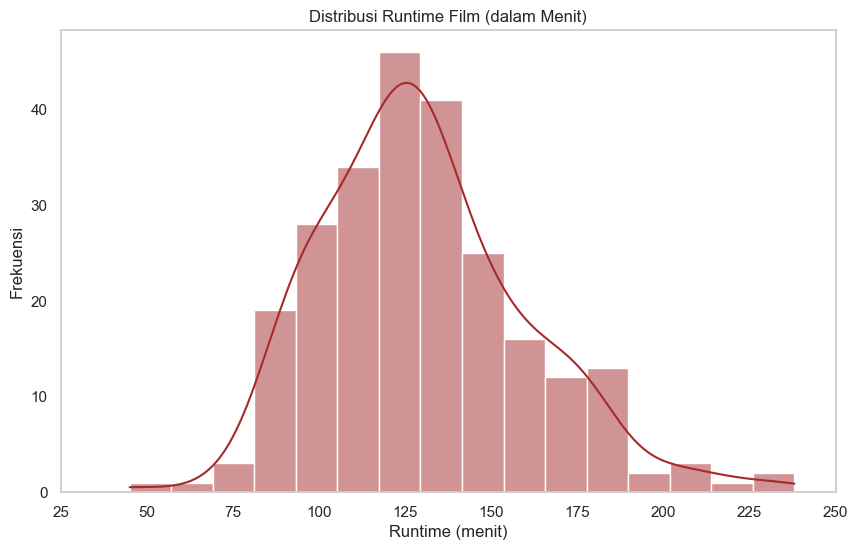

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")
df = pd.DataFrame(data)

# Fungsi untuk konversi runtime ke menit
def convert_runtime_to_minutes(runtime_str):
    if pd.isna(runtime_str):
        return None
    
    total_minutes = 0
    parts = runtime_str.split()
    
    i = 0
    while i < len(parts):
        if parts[i].isdigit():
            if i + 1 < len(parts) and parts[i + 1].startswith('hour'):
                total_minutes += int(parts[i]) * 60
                i += 1  # Skip the next part ('hour' or 'hours')
            elif i + 1 < len(parts) and parts[i + 1].startswith('minute'):
                total_minutes += int(parts[i])
                i += 1  # Skip the next part ('minute' or 'minutes')
            else:
                # Handle case where there's just a number without 'hour' or 'minute' following
                # Assuming it's minutes if not explicitly stated
                total_minutes += int(parts[i])
        i += 1
    
    return total_minutes

# Menggunakan fungsi untuk mengubah kolom Runtime menjadi menit
df['Runtime (minutes)'] = df['Runtime'].apply(convert_runtime_to_minutes)

# Mengatur gaya plot menggunakan Seaborn
sns.set(style="whitegrid")

# Membuat histogram distribusi Runtime dalam menit dengan KDE menggunakan Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df['Runtime (minutes)'], kde=True, color='brown')
plt.title('Distribusi Runtime Film (dalam Menit)')
plt.xlabel('Runtime (menit)')
plt.ylabel('Frekuensi')
plt.grid(False)

# Menyesuaikan skala sumbu x untuk menampilkan label dalam format menit
plt.xticks(ticks=plt.xticks()[0], labels=[f'{int(tick)}' for tick in plt.xticks()[0]])

plt.show()


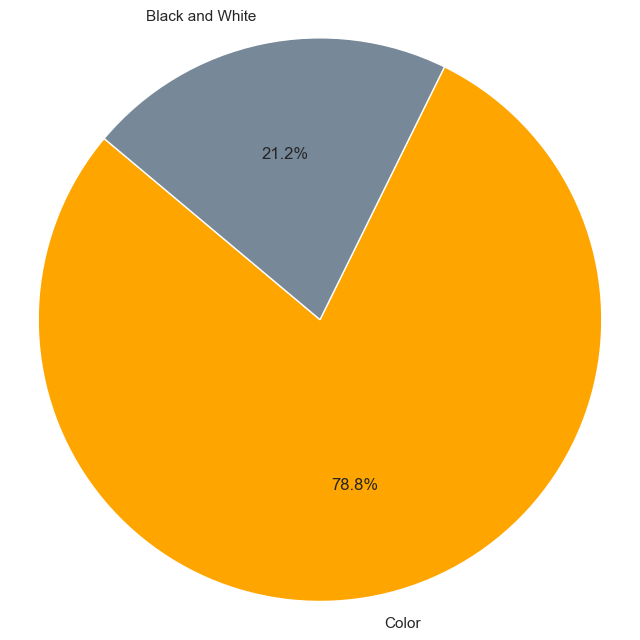

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Set the plot style
sns.set(style="whitegrid")

# Hitung jumlah kemunculan setiap warna
color_counts = data['Color'].value_counts()

# Definisi warna untuk setiap kategori
colors = ['orange', 'lightslategrey']

# Buat pie chart Composition of Movie Colors
plt.figure(figsize=(8, 8))
plt.pie(color_counts, labels=color_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Memastikan lingkaran berbentuk lingkaran
plt.show()


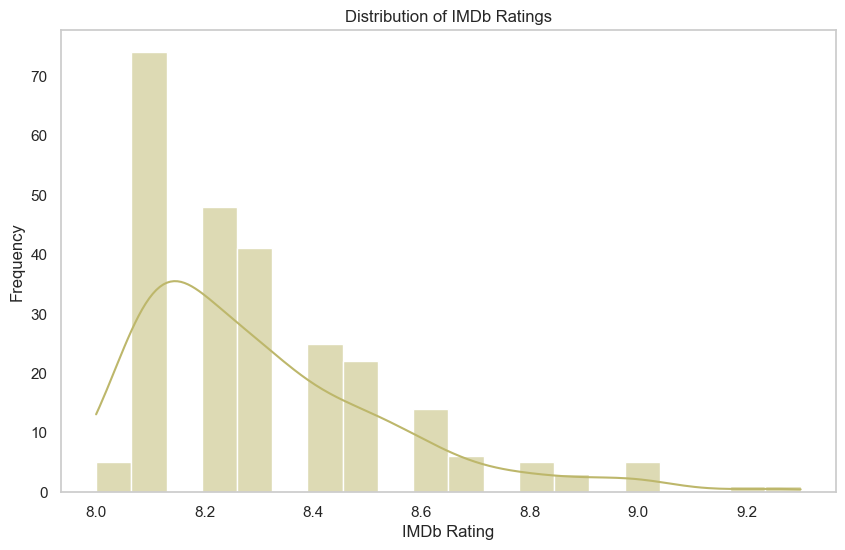

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# 1. Histogram IMDb Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['IMDb Rating'], bins=20, kde=True, color='darkkhaki')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()



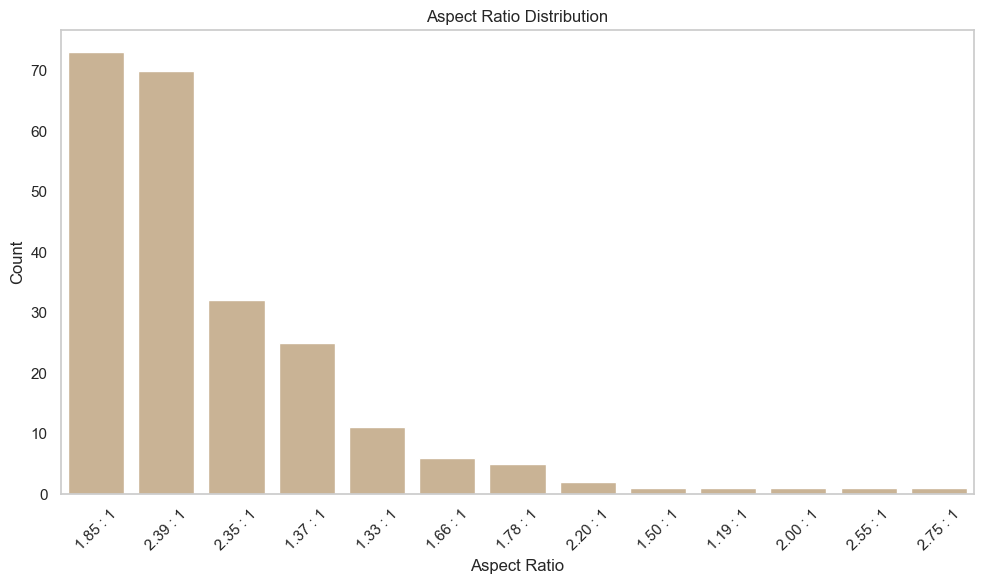

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")
#  Aspect Ratio Distribution
aspect_ratio_counts = data['Aspect ratio'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=aspect_ratio_counts.index, y=aspect_ratio_counts.values, color='tan')
plt.xticks(rotation=45)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

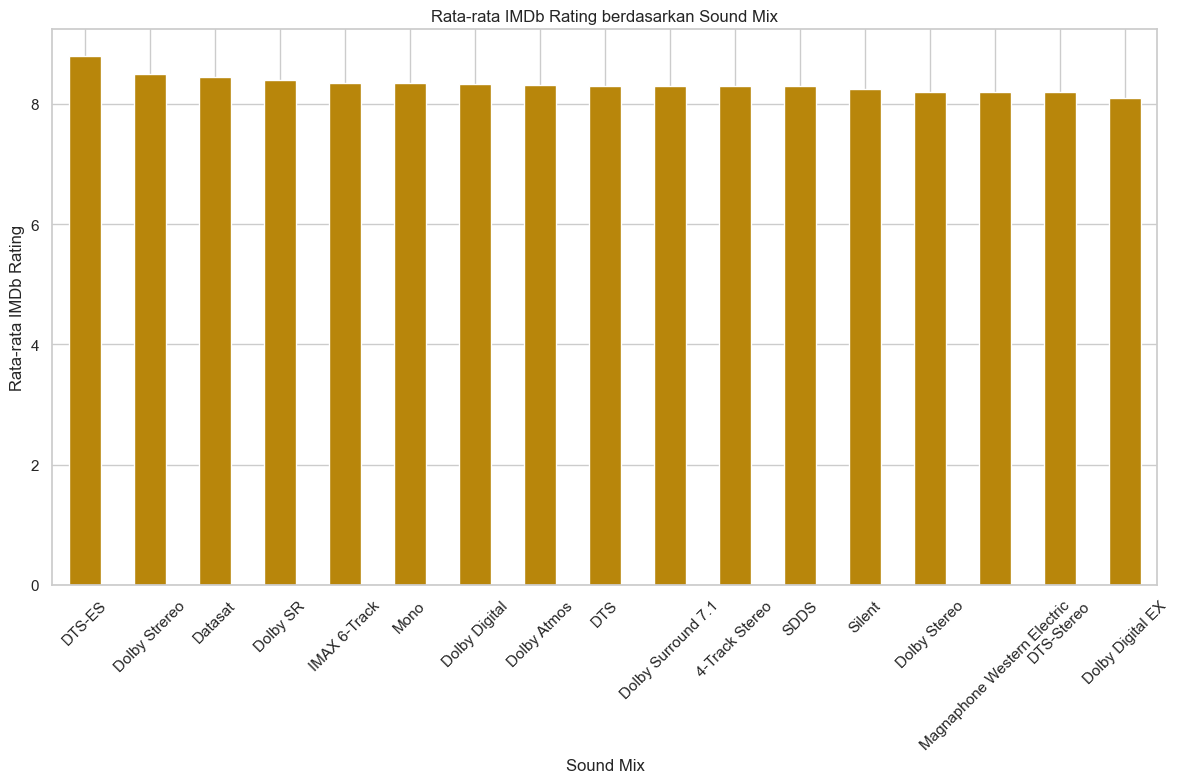

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Menghitung rata-rata IMDb Rating berdasarkan Sound Mix
rating_by_sound_mix = data.groupby('Sound mix')['IMDb Rating'].mean().sort_values(ascending=False)

# Plotting diagram bar
plt.figure(figsize=(12, 8))
rating_by_sound_mix.plot(kind='bar', color='darkgoldenrod')
plt.title('Rata-rata IMDb Rating berdasarkan Sound Mix')
plt.xlabel('Sound Mix')
plt.ylabel('Rata-rata IMDb Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


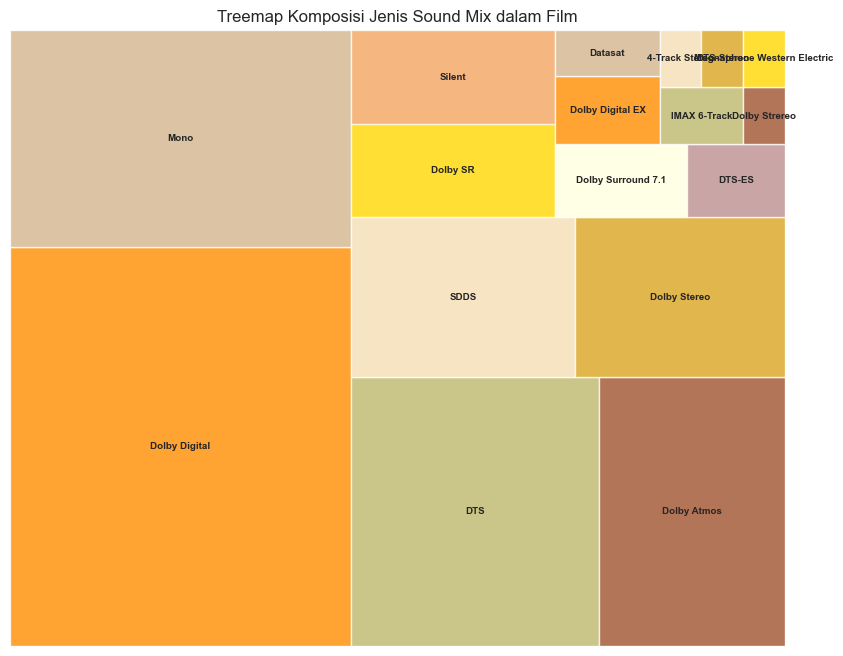

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # Library untuk membuat treemap

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Menghitung jumlah kemunculan setiap jenis Sound Mix
sound_mix_counts = data['Sound mix'].value_counts()

# Definisi warna untuk setiap kategori
colors = ['darkorange', 'tan', 'darkkhaki', 'sienna', 'wheat', 'goldenrod', 'gold', 'sandybrown', 'lightyellow', 'rosybrown']

# Plotting treemap
plt.figure(figsize=(10, 8))
squarify.plot(sizes=sound_mix_counts.values, label=sound_mix_counts.index, alpha=0.8, text_kwargs={'fontsize': 7, 'fontweight': 'bold'}, color=colors)
plt.title('Treemap Komposisi Jenis Sound Mix dalam Film')
plt.axis('off')  # Menghilangkan sumbu
plt.show()


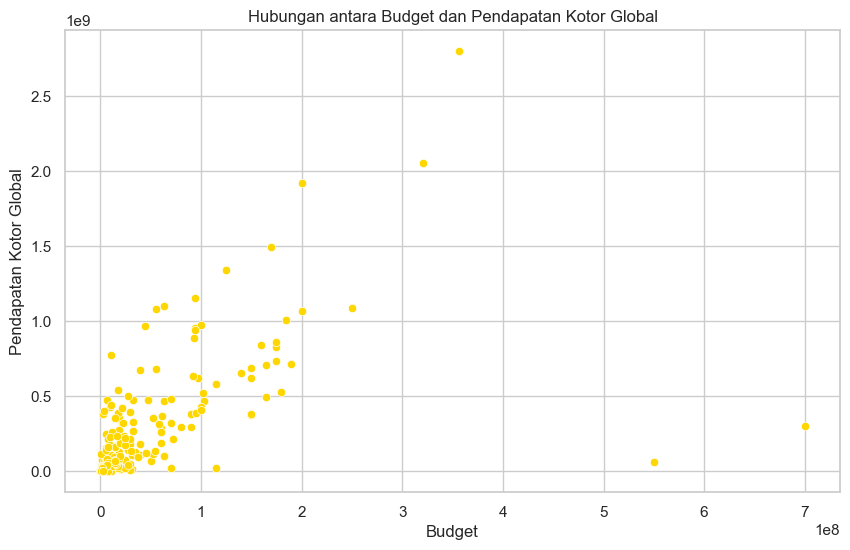

In [49]:
# Hubungan Budget dan Pendapatan Kotor Global
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Budget', y='Gross Worldwide', data=data, color='gold')
plt.title('Hubungan antara Budget dan Pendapatan Kotor Global')
plt.xlabel('Budget')
plt.ylabel('Pendapatan Kotor Global')
plt.grid(True)
plt.show()


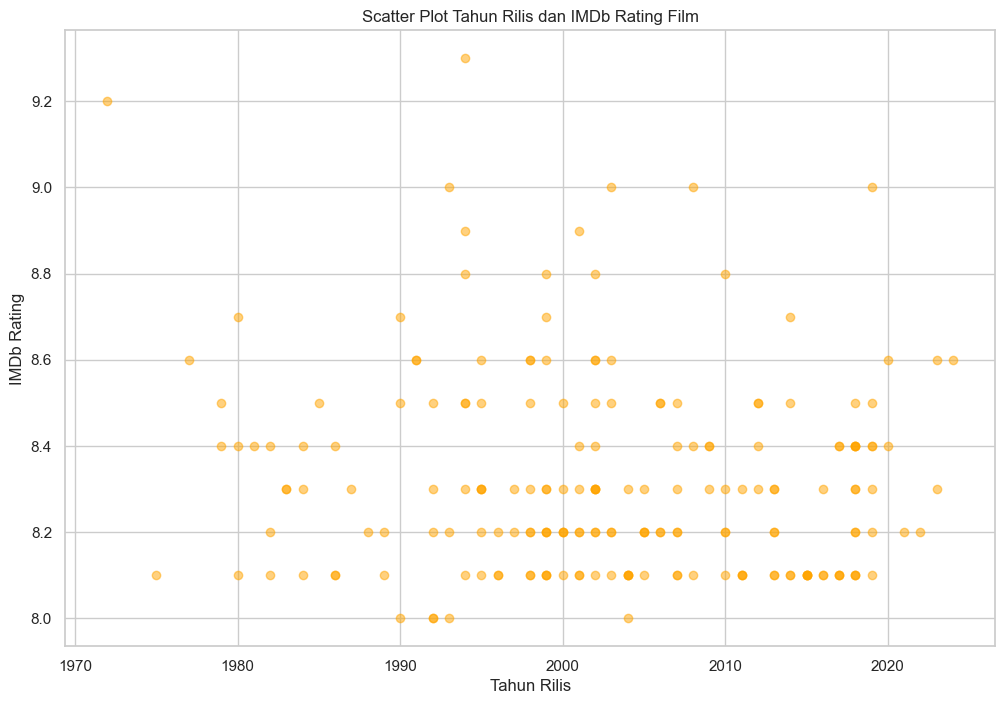

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Mengambil kolom 'IMDb Rating' dan 'Opening Weekend Date' yang tidak kosong
data = data[['IMDb Rating', 'Opening Weekend Date']].dropna()

# Mengubah format 'Opening Weekend Date' ke format datetime
data['Opening Weekend Date'] = pd.to_datetime(data['Opening Weekend Date'], errors='coerce')

# Mendapatkan tahun dari tanggal rilis film
data['Year'] = data['Opening Weekend Date'].dt.year

# Membuang baris dengan tahun yang kosong
data = data.dropna(subset=['Year'])

# Plotting scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(data['Year'], data['IMDb Rating'], alpha=0.5, color='orange')
plt.title('Scatter Plot Tahun Rilis dan IMDb Rating Film')
plt.xlabel('Tahun Rilis')
plt.ylabel('IMDb Rating')
plt.grid(True)
plt.show()


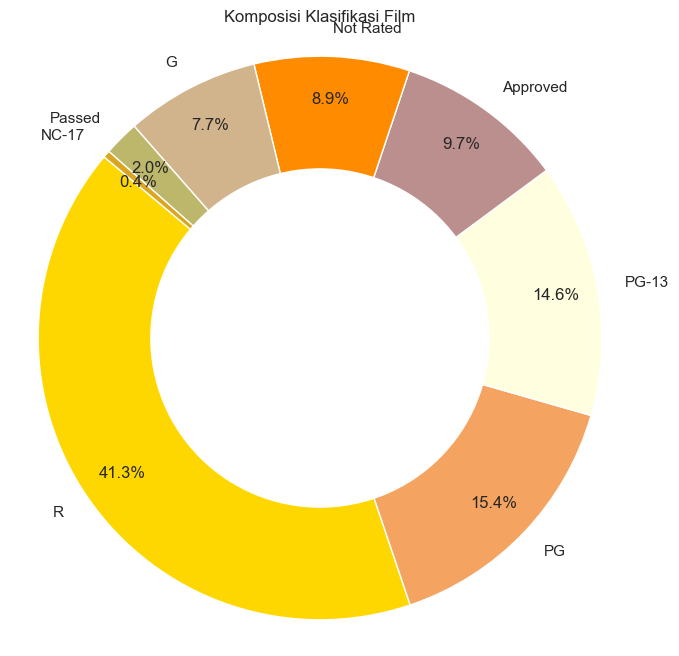

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Menghitung jumlah kemunculan setiap klasifikasi
classification_counts = data['Classifications'].value_counts()
colors = ['gold', 'sandybrown', 'lightyellow', 'rosybrown', 'darkorange', 'tan', 'darkkhaki', 'goldenrod']

# Plotting donut chart
plt.figure(figsize=(8, 8))

# Outer pie chart (lapisan luar)
plt.pie(classification_counts, labels=classification_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=colors)
# Inner pie chart (lapisan dalam)
plt.pie([1], radius=0.6, colors='white')

plt.title('Komposisi Klasifikasi Film')
plt.axis('equal')  # Memastikan lingkaran berbentuk lingkaran
plt.show()


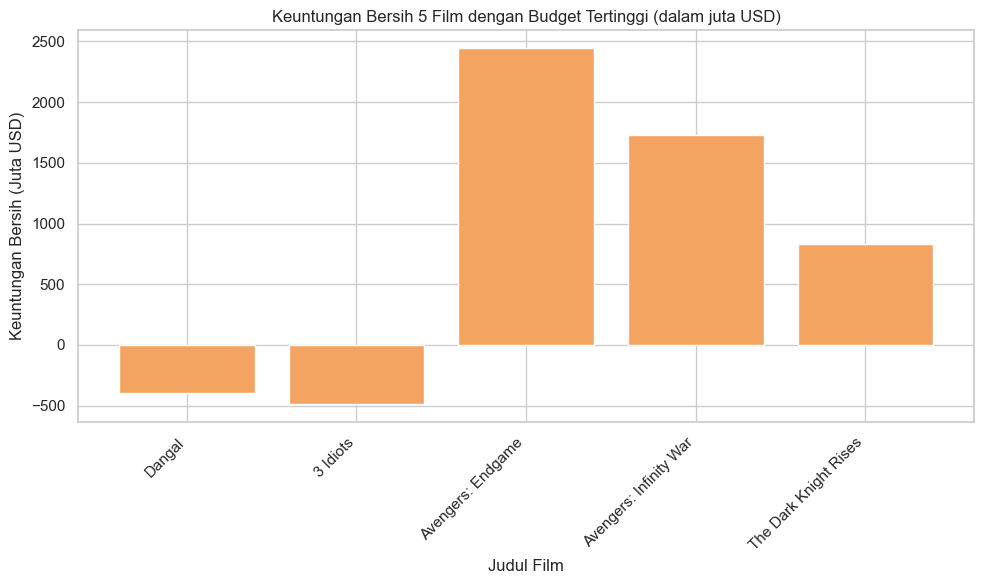

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Contoh dataframe (ganti dengan dataframe sesungguhnya)
# Membaca data dari file CSV
data = pd.read_csv("C:\\Users\\ACER\\imdb_top_250_cleaned.csv")

# Menghitung keuntungan bersih (gross profit)
data['Gross Profit'] = data['Gross Worldwide'] - data['Budget']

# Mengurutkan berdasarkan budget secara menurun
top_budget_films = data.nlargest(5, 'Budget')

# Plotting bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_budget_films['Title'], top_budget_films['Gross Profit'] / 1e6, color='sandybrown')
plt.title('Keuntungan Bersih 5 Film dengan Budget Tertinggi (dalam juta USD)')
plt.xlabel('Judul Film')
plt.ylabel('Keuntungan Bersih (Juta USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
